In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function


import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__) #1.15.0
print(keras.__version__) #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{1-f(x_{T,i},\theta')}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it $\mu$ and $\sigma$ values in addition to $X_i\sim\mathcal{N}(\mu, \sigma)$.

First we uniformly sample $\mu$ and $\sigma$ values in some range

In [3]:
n_data_points = 5*10**6
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

sigma_min = 0.5
sigma_max = 4.5
sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

We then sample from normal distributions with these $\mu$ and $\sigma$ values.

In [4]:
X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i]) for i in range(n_data_points)] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu_values[i], sigma_values[i]), mu_values[i], sigma_values[i]) for i in range(n_data_points)]

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [$\mu_{min}, \mu_{max}$] and [$\sigma_{min}, \sigma_{max}$].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((3,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam',  metrics=['accuracy'])

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
               epochs=200, 
               batch_size = 10000,
               validation_data = (X_test, Y_test),
               callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000000 samples, validate on 2000000 samples
Epoch 1/200





8000000/8000000 [==============================] - 13s 2us/step - loss: 0.5176 - acc: 0.7299 - val_loss: 0.5064 - val_acc: 0.7382
Epoch 2/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5053 - acc: 0.7387 - val_loss: 0.5053 - val_acc: 0.7386
Epoch 3/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5051 - acc: 0.7388 - val_loss: 0.5053 - val_acc: 0.7387
Epoch 4/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5051 - acc: 0.7387 - val_loss: 0.5053 - val_acc: 0.7386
Epoch 5/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5051 - acc: 0.7388 - val_loss: 0.5051 - val_acc: 0.7388
Epoch 6/200
8000000/8000000 [==============================] - 12s 1us/step - loss: 0.5050 - acc: 0.7388 - val_loss: 0.5052 - val_acc:

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [8]:
theta0_param = (0, 1)

def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

# from analytical formula for normal distributions
def analytical_reweight(events, mu1, sigma1, mu0 = theta0_param[0], sigma0 = theta0_param[1]): 
    weights = (sigma0/sigma1)*K.exp(-0.5*(((events-mu1)/sigma1)**2-((events-mu0)/sigma0)**2))
    #weights = K.expand_dims(weights, axis = 1)
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

In [9]:
mu1 = 1
sigma1 = 1.5
assert mu1>=mu_min and mu1<=mu_max # choose mu1 in valid range
assert sigma1>=sigma_min and sigma1<=sigma_max # choose mu1 in valid range
X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(mu1, sigma1, n_data_points)

In [10]:
X_input = np.array([(x, mu1, sigma1) for x in X0_val])

In [11]:
weights = reweight(tf.convert_to_tensor(X_input, dtype = tf.float32))
analytical_weights = analytical_reweight(X0_val, mu1, sigma1)
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

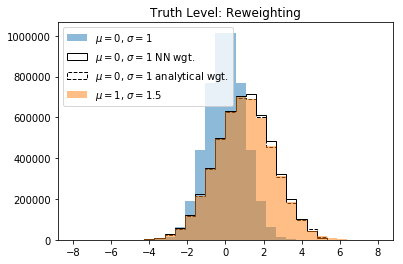

In [12]:
bins = np.linspace(-8,8,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$, $\sigma=1$ NN wgt.',
         weights=weights, histtype='step', color='k')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights, histtype='step', linestyle = '--',color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Truth Level: Reweighting")
plt.show()

# Saving Model

In [13]:
'''
model_json = dctr_model.to_json()
with open("2d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("2d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("2d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("2d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [14]:
N = 10**6
theta0_param = (0,1) #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = (1,1.5) #this is the data (the target)

theta0 = np.random.normal(theta0_param[0],theta0_param[1],N)
theta1 = np.random.normal(theta1_param[0],theta1_param[1],N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0,theta1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.)

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

# Loading Model

In [15]:
# load json and create model
'''
json_file = open('dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("dctr_model.h5")
print("Loaded model from disk")
'''


'\njson_file = open(\'dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("dctr_model.h5")\nprint("Loaded model from disk")\n'

In [16]:
# Change to True for analytical_reweight

reweight_analytically = False

# Cross Section for $\mu$

In [17]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              min_delta = 0.00005,
                              restore_best_weights=True)

def my_loss_wrapper(inputs,val=0):
    x  = inputs
    x = K.gather(x, np.arange(batch_size))

    theta = 0. #starting value
    theta_prime = [val, theta1_param[1]] #fixed theta_sigma = sigma_truth
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = (x.shape[0], 2))*theta_prime
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(events = x, 
                                mu1 = theta_prime[0], 
                                sigma1 = theta_prime[1]) 
    
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [18]:
thetas = np.linspace(-2,2,17)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, 
              epochs=100, batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1, callbacks = [earlystopping])
    lvals+=[np.min(model.history.history['loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1152 - acc: 0.5805
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1145 - acc: 0.5799
Epoch 3/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1145 - acc: 0.5809
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1145 - acc: 0.5805
Epoch 5/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1145 - acc: 0.5809
[0.11448619325086475]
testing theta = : -1.75
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.1274 - acc: 0.5909
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1274 - acc: 0.5907
Epoch 3/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1274 - acc: 0.5906
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2351 - acc: 0.6659
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2351 - acc: 0.6655
[0.11448619325086475, 0.12735259186849, 0.14110893625020982, 0.15553031770139933, 0.17061586268246173, 0.18487819803506136, 0.1982151596918702, 0.21152295786887407, 0.2240594956576824, 0.23509092042595148]
testing theta = : 0.5
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.2448 - acc: 0.6697
Epoch 2/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.2449 - acc: 0.6695
Epoch 3/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2448 - acc: 0.6687
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2448 - acc: 0.6691
Epoch 5/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2449 - acc: 0.6693
Epoch 6/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2448 - acc: 0.3369
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2448 - acc: 0.3375
Epoch 5/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2449 - acc: 0.3355
Epoch 6/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2451 - acc: 0.3353
[0.11448619325086475, 0.12735259186849, 0.14110893625020982, 0.15553031770139933, 0.17061586268246173, 0.18487819803506136, 0.1982151596918702, 0.21152295786887407, 0.2240594956576824, 0.23509092042595148, 0.24478134578466415, 0.25082467117905616, 0.2530105312243104, 0.25103947277367117, 0.2447706816494465]
testing theta = : 1.75
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.2363 - acc: 0.3417
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2367 - acc: 0.3396
Epoch 3

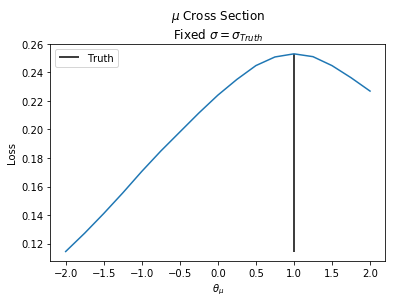

In [19]:
plt.plot(thetas,lvals)
plt.title("$\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-\mu cross section.png")
plt.show()

# Cross Section for $\sigma$

In [20]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              min_delta = 0.00005,
                              restore_best_weights=True)

def my_loss_wrapper(inputs,val=0):
    x  = inputs
    x = K.gather(x, np.arange(batch_size))

    theta = 0. #starting value
    theta_prime = [theta1_param[0], val] #fixed theta_mu = mu_truth
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = (x.shape[0], 2))*theta_prime
    #combining and reshaping into correct format:
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(events = x, 
                                mu1 = theta_prime[0], 
                                sigma1 = theta_prime[1]) 
    
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
thetas = np.linspace(0.5,4.5,17)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, 
              epochs=100, batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1, callbacks = [earlystopping])
    lvals+=[np.min(model.history.history['loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : 0.5
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.1732 - acc: 0.4910
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1717 - acc: 0.4887
Epoch 3/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1717 - acc: 0.4884
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1716 - acc: 0.4886
Epoch 5/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.1716 - acc: 0.4886
[0.1716344181969762]
testing theta = : 0.75
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.2126 - acc: 0.4916
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2125 - acc: 0.4918
Epoch 3/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2125 - acc: 0.4919
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2529 - acc: 0.4957
Epoch 6/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.2531 - acc: 0.4928
[0.1716344181969762, 0.21246619226783514, 0.2347348095551133, 0.24865210366249085, 0.25277938179671766]
testing theta = : 1.75
Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.2502 - acc: 0.4709
Epoch 2/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2509 - acc: 0.4654
Epoch 3/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.2500 - acc: 0.4629
Epoch 4/100
2000000/2000000 [==============================] - 8s 4us/step - loss: 0.2500 - acc: 0.4625
Epoch 5/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.2502 - acc: 0.4650
Epoch 6/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.2499 - acc: 0.4584
Epoc

Train on 2000000 samples, validate on 0 samples
Epoch 1/100
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.1932 - acc: 0.4812
Epoch 2/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1920 - acc: 0.4811
Epoch 3/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1900 - acc: 0.4807
Epoch 4/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1907 - acc: 0.4803
Epoch 5/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1909 - acc: 0.4802
Epoch 6/100
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.1903 - acc: 0.4828
[0.1716344181969762, 0.21246619226783514, 0.2347348095551133, 0.24865210366249085, 0.25277938179671766, 0.24988520641624928, 0.24302658019214868, 0.23533886105567217, 0.22689354773610831, 0.2194884277060628, 0.21167879273742438, 0.2042645138502121, 0.19716691149771212, 0.19002596306800842]
testing theta = : 4.0
Train on 20000

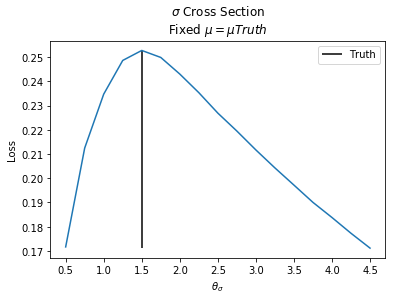

In [22]:
plt.plot(thetas,lvals)
plt.title("$\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-\sigma cross section.png")
plt.show()

# Creating Model

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

# Building and Training Fitting Model

In [23]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3,
                              restore_best_weights=True)

In [24]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=(2,),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr_initial = 5e-1 #smaller learning rate yields better precision
iterations = 75 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr_initial)

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    
    
    theta = 0. #starting value
    #Getting theta0:
    if train_theta == False:
        x = K.gather(x, np.arange(1000))
        theta_prime = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array 
    else:
        x = K.gather(x, np.arange(batch_size))
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same shape as inputs, with val in every entry 
    concat_input_and_params = K.ones(shape = (x.shape[0], 2), dtype=tf.float32)*theta_prime
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(events = x, 
                                mu1 = theta_prime[0], 
                                sigma1 = theta_prime[1]) 
    
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        #t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [25]:
for iteration in range(iterations):    
    print("Iteration: ", iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=20, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)
    
    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):,0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):,1]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate((argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu>= iteration - index_refine[-1] -20]
            
    extrema_sigma = np.concatenate((argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''
    
    if (len(extrema_mu) == 0) or (len(extrema_sigma) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10
        
        mean_fit = np.array([[np.mean(fit_vals_mu[len(fit_vals_mu)-4:len(fit_vals_mu)]),
                              np.mean(fit_vals_sigma[len(fit_vals_sigma)-4:len(fit_vals_sigma)])]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    

Iteration:  0
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6016 - acc: 0.6669
Epoch 2/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5956 - acc: 0.6722
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5953 - acc: 0.6723
Epoch 4/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5952 - acc: 0.6723
Epoch 5/20
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.5952 - acc: 0.6723
Epoch 6/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5952 - acc: 0.6723
Epoch 7/20
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.5952 - acc: 0.6724
Epoch 8/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5952 - acc: 0.6724
Epoch 9/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.5952 - acc: 0.6723

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 9s 4us/step - loss: 0.6839 - acc: 0.6681
Epoch 4/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6838 - acc: 0.6679
Epoch 5/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6837 - acc: 0.6677
Epoch 6/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6837 - acc: 0.6678
Epoch 7/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6837 - acc: 0.6685
Epoch 8/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6837 - acc: 0.6683
Epoch 9/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6837 - acc: 0.6681
Epoch 10/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6838 - acc: 0.6689
Epoch 11/20
2000000/2000000 [==============================] - 9s 4us/step - loss: 0.6836 - acc: 0.6687
Epoch 12/20
2000000/2000000 [==============================] - 9s 5us/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6875 - acc: 0.6632
Epoch 5/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6876 - acc: 0.6645
Epoch 6/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6874 - acc: 0.6647
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.6914 - acc: 0.5064
. theta fit =  [0.84386647 1.2620392 ]
Iteration:  4
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6907 - acc: 0.5943
Epoch 2/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6898 - acc: 0.5825
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6898 - acc: 0.5822
Epoch 4/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6897 - acc: 0.5794
Epoch 5/20


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7002 - acc: 0.3396
Epoch 9/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7006 - acc: 0.3459
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.7003 - acc: 0.3569
. theta fit =  [0.855585 1.27383 ]
Iteration:  6
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6920 - acc: 0.5705
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.6911 - acc: 0.5819
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6910 - acc: 0.5805
Epoch 4/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6910 - acc: 0.5801
Epoch 5/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6908 - acc: 0.5828
Epoch 6/20
200

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 9s 5us/step - loss: 0.6916 - acc: 0.5823
Epoch 8/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.6915 - acc: 0.5822
Epoch 9/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.6914 - acc: 0.5811
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 9s 4us/step - loss: -0.6914 - acc: 0.5881
. theta fit =  [1.1052521 1.5235598]
Refining learning rate
Iteration:  9
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7006 - acc: 0.5107
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.6999 - acc: 0.5268
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7000 - acc: 0.5120
Epoch 4/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7003 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7012 - acc: 0.4565
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7012 - acc: 0.4746
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7010 - acc: 0.4697
Epoch 5/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7015 - acc: 0.4533
Epoch 6/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7012 - acc: 0.4603
Epoch 7/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7012 - acc: 0.4649
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 9s 5us/step - loss: -0.7007 - acc: 0.5159
. theta fit =  [1.0310004 1.4974391]
Iteration:  13
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.7023 - acc: 0.4019
Epoch 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7012 - acc: 0.3951
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.7019 - acc: 0.3455
. theta fit =  [1.0555887 1.5220275]
Iteration:  16
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.7029 - acc: 0.3888
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.3718
Epoch 3/20
2000000/2000000 [==============================] - 9s 5us/step - loss: 0.7005 - acc: 0.3932
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.3711
Epoch 5/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.3830
Epoch 6/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7008 - acc: 0.3745
Traini

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7014 - acc: 0.5002
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.7007 - acc: 0.3786
. theta fit =  [0.9810763 1.4975632]
Iteration:  19
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.7008 - acc: 0.4730
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7014 - acc: 0.5057
Epoch 3/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7011 - acc: 0.4994
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7021 - acc: 0.5138
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.7007 - acc: 0.5681
. theta fit =  [1.0063975 1.4722416]
Refining 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.4759
Epoch 5/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7012 - acc: 0.4934
Epoch 6/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7013 - acc: 0.4842
Epoch 7/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7007 - acc: 0.4724
Epoch 8/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7018 - acc: 0.4916
Epoch 9/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.5010
Epoch 10/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7008 - acc: 0.4643
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 11s 5us/step - loss: -0.7011 - acc: 0.5312
. theta fit =  [1.0036224 1.4824209]
Iteration:  23
Training g
Train on 2000000 samples, validate on 0 samples
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7021 - acc: 0.4677
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7008 - acc: 0.4740
Epoch 5/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7013 - acc: 0.4774
Epoch 6/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7014 - acc: 0.4874
Epoch 7/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.4533
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 11s 6us/step - loss: -0.7005 - acc: 0.5032
. theta fit =  [1.000966  1.4797518]
Iteration:  26
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.7030 - acc: 0.4659
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7010 - acc: 0.4781
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7010 - acc: 0.4779
Epoch 7/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7015 - acc: 0.4876
Epoch 8/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7013 - acc: 0.4484
Epoch 9/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7008 - acc: 0.4822
Epoch 10/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7006 - acc: 0.4523
Epoch 11/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7014 - acc: 0.4737
Epoch 12/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7008 - acc: 0.4756
Epoch 13/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7021 - acc: 0.4843
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.7006 - acc: 0.4146
. theta 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7017 - acc: 0.4495
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.7009 - acc: 0.5025
. theta fit =  [1.0055852 1.4802423]
Iteration:  33
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.7065 - acc: 0.4511
Epoch 2/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7010 - acc: 0.4405
Epoch 3/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7009 - acc: 0.4703
Epoch 4/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7014 - acc: 0.4653
Epoch 5/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7008 - acc: 0.4786
Epoch 6/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7022 - acc: 0.4612
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7010 - acc: 0.4780
Epoch 3/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7015 - acc: 0.4540
Epoch 4/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7009 - acc: 0.4820
Epoch 5/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7005 - acc: 0.4776
Epoch 6/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7011 - acc: 0.4701
Epoch 7/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7021 - acc: 0.4763
Epoch 8/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7012 - acc: 0.4858
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.7004 - acc: 0.5017
. theta fit =  [1.0052999 1.4803805]
Iteration:  36
Training g
Train on 2000000 samples, validate on 0 samples
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7013 - acc: 0.4649
Epoch 3/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7006 - acc: 0.4657
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.7009 - acc: 0.4719
Epoch 5/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7008 - acc: 0.4720
Epoch 6/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7013 - acc: 0.4752
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.7006 - acc: 0.4566
. theta fit =  [1.0049902 1.4800644]
Iteration:  39
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 19s 10us/step - loss: 0.7024 - acc: 0.4697
Epoch 2/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7015 - acc: 0.4615
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 20s 10us/step - loss: 0.7123 - acc: 0.4548
Epoch 2/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7005 - acc: 0.4860
Epoch 3/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7001 - acc: 0.4825
Epoch 4/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7014 - acc: 0.4713
Epoch 5/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7010 - acc: 0.4769
Epoch 6/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7016 - acc: 0.5087
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 13s 7us/step - loss: -0.7027 - acc: 0.5058
. theta fit =  [1.0059499 1.4803861]
Iteration:  42
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 20s 10us/step - loss: 0.7163 - acc: 0.4826
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7011 - acc: 0.5025
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.7008 - acc: 0.4902
. theta fit =  [1.0055934 1.4801892]
Iteration:  44
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 20s 10us/step - loss: 0.7016 - acc: 0.4739
Epoch 2/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7009 - acc: 0.4799
Epoch 3/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7011 - acc: 0.4735
Epoch 4/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7023 - acc: 0.4779
Epoch 5/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7008 - acc: 0.4795
Epoch 6/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7009 - acc: 0.4981
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7022 - acc: 0.4816
Epoch 5/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7020 - acc: 0.4788
Epoch 6/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7012 - acc: 0.4820
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.7011 - acc: 0.4803
. theta fit =  [1.0056945 1.4802237]
Iteration:  47
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 21s 10us/step - loss: 0.7026 - acc: 0.4731
Epoch 2/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.7005 - acc: 0.4460
Epoch 3/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7034 - acc: 0.4923
Epoch 4/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7006 - acc: 0.4579
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7006 - acc: 0.4869
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7007 - acc: 0.4704
Epoch 5/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7010 - acc: 0.4745
Epoch 6/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7022 - acc: 0.4882
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.7004 - acc: 0.5025
. theta fit =  [1.0058725 1.4803313]
Refining learning rate
Iteration:  58
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 23s 12us/step - loss: 0.7076 - acc: 0.4729
Epoch 2/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.7009 - acc: 0.4842
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7019 - acc: 0.4896
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7005 - acc: 0.4888
Epoch 5/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7011 - acc: 0.4909
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 17s 8us/step - loss: -0.7016 - acc: 0.4464
. theta fit =  [1.005899  1.4803501]
Iteration:  62
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7059 - acc: 0.4647
Epoch 2/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7014 - acc: 0.4912
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7008 - acc: 0.4916
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7006 - acc: 0.5039
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7003 - acc: 0.4908
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7008 - acc: 0.4806
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7006 - acc: 0.4834
Epoch 5/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7009 - acc: 0.4877
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.7005 - acc: 0.4137
. theta fit =  [1.0059029 1.4803541]
Iteration:  65
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7172 - acc: 0.4521
Epoch 2/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7009 - acc: 0.4537
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7035 - acc: 0.4928
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7010 - acc: 0.4969
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 17s 8us/step - loss: -0.7014 - acc: 0.5013
. theta fit =  [1.0059068 1.4803501]
Iteration:  68
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.7218 - acc: 0.4593
Epoch 2/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7013 - acc: 0.4569
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7009 - acc: 0.4959
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7008 - acc: 0.5011
Epoch 5/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7015 - acc: 0.5016
Epoch 6/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7008 - acc: 0.5034
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7017 - acc: 0.5034
Epoch 5/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7010 - acc: 0.4949
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.7004 - acc: 0.4566
. theta fit =  [1.0059096 1.4803522]
Iteration:  71
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 25s 13us/step - loss: 0.7137 - acc: 0.4781
Epoch 2/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7017 - acc: 0.5090
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7002 - acc: 0.4817
Epoch 4/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.7024 - acc: 0.4820
Epoch 5/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7006 - acc: 0.5111
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 26s 13us/step - loss: 0.7121 - acc: 0.4343
Epoch 2/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7022 - acc: 0.4996
Epoch 3/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7006 - acc: 0.4528
Epoch 4/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7015 - acc: 0.4997
Epoch 5/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7014 - acc: 0.5007
Epoch 6/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.7014 - acc: 0.5193
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.7006 - acc: 0.5041
. theta fit =  [1.0059109 1.4803534]
Iteration:  74
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 25s 13us/step - loss: 0.7219 - acc: 0.4381
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



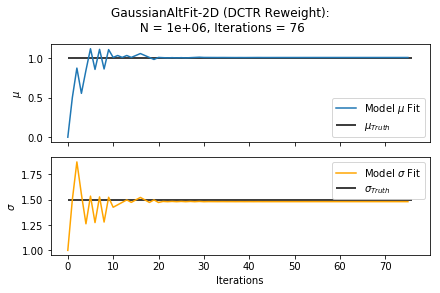

In [26]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
axs[0].plot(fit_vals[:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:,1], label='Model $\sigma$ Fit', color ='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()


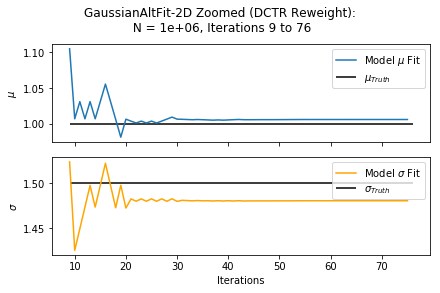

In [27]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}".format(N,index_refine[1], len(fit_vals)))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:,0])), fit_vals[index_refine[1]:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], index_refine[1], len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:,1])), fit_vals[index_refine[1]:,1], label='Model $\sigma$ Fit', color = 'orange')
axs[1].hlines(theta1_param[1], index_refine[1], len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(N,index_refine[1], len(fit_vals)))
plt.show()



## Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [28]:
reweight_analytically = True

In [29]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(monitor='loss',
                              patience = 3, 
                              restore_best_weights=True)

In [30]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=(2,),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False
index_refine = np.array([0])
batch_size = 2*N
lr_initial = 5e-1 #smaller learning rate yields better precision
iterations = 75 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr_initial)

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    
    
    theta = 0. #starting value
    #Getting theta0:
    if train_theta == False:
        x = K.gather(x, np.arange(1000))
        theta_prime = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array 
    else:
        x = K.gather(x, np.arange(batch_size))
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same shape as inputs, with val in every entry 
    concat_input_and_params = K.ones(shape = (x.shape[0], 2), dtype=tf.float32)*theta_prime
    data = K.concatenate((x, concat_input_and_params), axis=-1)
    
    if reweight_analytically == False: #NN reweight
        w = reweight(data)
    else: # analytical reweight
        w = analytical_reweight(events = x, 
                                mu1 = theta_prime[0], 
                                sigma1 = theta_prime[1]) 
    
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        #t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [31]:
for iteration in range(iterations):    
    print("Iteration: ", iteration )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=20, batch_size=1000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)
    
    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10
    
    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):,0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):,1]
    
    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate((argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu>= iteration - index_refine[-1] -20]
            
    extrema_sigma = np.concatenate((argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''
    
    if (len(extrema_mu) == 0) or (len(extrema_sigma) == 0): # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >= 6): #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print("Refining learning rate")
        optimizer.lr = optimizer.lr/10
        
        mean_fit = np.array([[np.mean(fit_vals_mu[len(fit_vals_mu)-4:len(fit_vals_mu)]),
                              np.mean(fit_vals_sigma[len(fit_vals_sigma)-4:len(fit_vals_sigma)])]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    

Iteration:  0
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 21s 11us/step - loss: 0.6016 - acc: 0.6652
Epoch 2/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.5946 - acc: 0.6724
Epoch 3/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.5944 - acc: 0.6724
Epoch 4/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.5944 - acc: 0.6724
Epoch 5/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.5943 - acc: 0.6724
Epoch 6/20
2000000/2000000 [==============================] - 10s 5us/step - loss: 0.5943 - acc: 0.6723
Epoch 7/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.5943 - acc: 0.6724
Epoch 8/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.5943 - acc: 0.6724
Epoch 9/20
2000000/2000000 [==============================] - 11s 5us/step - loss: 0.5943 - ac

2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6918 - acc: 0.3486
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.6906 - acc: 0.3555
. theta fit =  [0.9125484 1.2738249]
Iteration:  6
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 24s 12us/step - loss: 0.6874 - acc: 0.5507
Epoch 2/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.6865 - acc: 0.5557
Epoch 3/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6865 - acc: 0.5556
Epoch 4/20
2000000/2000000 [==============================] - 11s 6us/step - loss: 0.6863 - acc: 0.5540
Epoch 5/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6864 - acc: 0.5504
Epoch 6/20
2000000/2000000 [==============================] - 12s 6us/step - loss: 0.6864 - acc: 0.5514
Epoch

2000000/2000000 [==============================] - 27s 14us/step - loss: 0.6949 - acc: 0.4880
Epoch 2/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6925 - acc: 0.4612
Epoch 3/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6921 - acc: 0.4939
Epoch 4/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6925 - acc: 0.4981
Epoch 5/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6929 - acc: 0.5434
Epoch 6/20
2000000/2000000 [==============================] - 13s 6us/step - loss: 0.6928 - acc: 0.4552
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 18s 9us/step - loss: -0.6930 - acc: 0.6173
. theta fit =  [1.0156368 1.5216408]
Iteration:  14
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 27s 14us/step - loss: 0.6934 - acc: 0.4332
Epo

. theta fit =  [0.9906519 1.4966017]
Refining learning rate
Iteration:  21
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 29s 14us/step - loss: 0.6970 - acc: 0.4669
Epoch 2/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6924 - acc: 0.4932
Epoch 3/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6935 - acc: 0.5136
Epoch 4/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6919 - acc: 0.5017
Epoch 5/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6932 - acc: 0.5269
Epoch 6/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6927 - acc: 0.5336
Epoch 7/20
2000000/2000000 [==============================] - 13s 7us/step - loss: 0.6932 - acc: 0.4922
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 19s 10us/step

2000000/2000000 [==============================] - 20s 10us/step - loss: -0.6921 - acc: 0.4785
. theta fit =  [1.0015501 1.496878 ]
Iteration:  29
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 30s 15us/step - loss: 0.7006 - acc: 0.4350
Epoch 2/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6928 - acc: 0.4999
Epoch 3/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6922 - acc: 0.4777
Epoch 4/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6935 - acc: 0.4564
Epoch 5/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6922 - acc: 0.5038
Epoch 6/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6920 - acc: 0.4811
Epoch 7/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6926 - acc: 0.4707
Epoch 8/20
2000000/2000000 [==============================] - 14s

2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6924 - acc: 0.4352
Epoch 6/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6923 - acc: 0.4784
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 22s 11us/step - loss: -0.6920 - acc: 0.4345
. theta fit =  [1.0057957 1.4968373]
Iteration:  37
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 31s 16us/step - loss: 0.7053 - acc: 0.4237
Epoch 2/20
2000000/2000000 [==============================] - 14s 7us/step - loss: 0.6918 - acc: 0.4264
Epoch 3/20
2000000/2000000 [==============================] - 20s 10us/step - loss: 0.6931 - acc: 0.4736
Epoch 4/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6924 - acc: 0.4743
Epoch 5/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6916 - acc: 0.4223
Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 33s 17us/step - loss: 0.7034 - acc: 0.4261
Epoch 2/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6917 - acc: 0.4462
Epoch 3/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6919 - acc: 0.4343
Epoch 4/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6922 - acc: 0.4581
Epoch 5/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6924 - acc: 0.4534
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 23s 11us/step - loss: -0.6918 - acc: 0.3389
. theta fit =  [1.0044904 1.494879 ]
Iteration:  45
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 34s 17us/step - loss: 0.7020 - acc: 0.4105
Epoch 2/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6918 - acc: 0.4538
Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6933 - acc: 0.4559
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 22s 11us/step - loss: -0.6913 - acc: 0.3504
. theta fit =  [1.0038122 1.4942005]
Iteration:  47
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 32s 16us/step - loss: 0.7089 - acc: 0.3931
Epoch 2/20
2000000/2000000 [==============================] - 21s 10us/step - loss: 0.6920 - acc: 0.4293
Epoch 3/20
2000000/2000000 [==============================] - 15s 7us/step - loss: 0.6919 - acc: 0.4728
Epoch 4/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6957 - acc: 0.4577
Epoch 5/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6923 - acc: 0.4501
Epoch 6/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6924 - acc: 0.4531
Tr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6922 - acc: 0.4914
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 23s 12us/step - loss: -0.6915 - acc: 0.5434
. theta fit =  [1.0024178 1.4928044]
Iteration:  51
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 40s 20us/step - loss: 0.6970 - acc: 0.4380
Epoch 2/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6920 - acc: 0.4653
Epoch 3/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6934 - acc: 0.4386
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6935 - acc: 0.5074
Epoch 5/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6920 - acc: 0.4532
Epoch 6/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6922 - acc: 0.4778
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6941 - acc: 0.4654
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6921 - acc: 0.4494
Epoch 5/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6931 - acc: 0.4466
Epoch 6/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6932 - acc: 0.4463
Epoch 7/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6933 - acc: 0.4790
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 23s 12us/step - loss: -0.6917 - acc: 0.4923
. theta fit =  [1.0024161 1.4928017]
Iteration:  53
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 36s 18us/step - loss: 0.7143 - acc: 0.4064
Epoch 2/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6933 - acc: 0.4246
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6923 - acc: 0.4430
Epoch 5/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6926 - acc: 0.4326
Epoch 6/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6923 - acc: 0.4274
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 24s 12us/step - loss: -0.6918 - acc: 0.4733
. theta fit =  [1.0026338 1.4930198]
Iteration:  55
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 38s 19us/step - loss: 0.7170 - acc: 0.4084
Epoch 2/20
2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6925 - acc: 0.4097
Epoch 3/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6927 - acc: 0.4430
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6949 - acc: 0.4508
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6931 - acc: 0.4588
Epoch 5/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6952 - acc: 0.4283
Epoch 6/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6931 - acc: 0.4764
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 30s 15us/step - loss: -0.6925 - acc: 0.4734
. theta fit =  [1.0026342 1.4930941]
Iteration:  57
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 36s 18us/step - loss: 0.7052 - acc: 0.4088
Epoch 2/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6918 - acc: 0.4483
Epoch 3/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6920 - acc: 0.4990
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6980 - acc: 0.4527
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6922 - acc: 0.4622
Epoch 7/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6958 - acc: 0.4480
Epoch 8/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6929 - acc: 0.4652
Epoch 9/20
2000000/2000000 [==============================] - 22s 11us/step - loss: 0.6912 - acc: 0.4256
Epoch 10/20
2000000/2000000 [==============================] - 15s 8us/step - loss: 0.6995 - acc: 0.4175
Epoch 11/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6939 - acc: 0.4644
Epoch 12/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6926 - acc: 0.4531
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 24s 12us/step - loss: -0.7199 - acc: 0.5087
. theta fit =  [1.0027479 1.4932077]
Iteration:  60
Training g
Train on 2000000 samples, validate on 0 samples


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6922 - acc: 0.4468
Epoch 3/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6924 - acc: 0.4744
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6924 - acc: 0.4833
Epoch 5/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6928 - acc: 0.4582
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 25s 13us/step - loss: -0.6921 - acc: 0.5479
. theta fit =  [1.0028251 1.4932075]
Iteration:  62
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 38s 19us/step - loss: 0.7253 - acc: 0.4278
Epoch 2/20
2000000/2000000 [==============================] - 20s 10us/step - loss: 0.6939 - acc: 0.4561
Epoch 3/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6922 - acc: 0.5140
Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000000/2000000 [==============================] - 25s 12us/step - loss: -0.6917 - acc: 0.4416
. theta fit =  [1.002786  1.4931684]
Iteration:  63
Training g
Train on 2000000 samples, validate on 0 samples
Epoch 1/20
2000000/2000000 [==============================] - 38s 19us/step - loss: 0.7015 - acc: 0.4443
Epoch 2/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6928 - acc: 0.4694
Epoch 3/20
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6937 - acc: 0.5226
Epoch 4/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6926 - acc: 0.4817
Epoch 5/20
2000000/2000000 [==============================] - 17s 8us/step - loss: 0.6909 - acc: 0.4795
Epoch 6/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6932 - acc: 0.4956
Epoch 7/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6970 - acc: 0.4593
Epoch 8/20
2000000/2000000 [==============================] - 16s

2000000/2000000 [==============================] - 17s 9us/step - loss: 0.6938 - acc: 0.4826
Epoch 5/20
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6922 - acc: 0.4918
Epoch 6/20
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6969 - acc: 0.4606
Epoch 7/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6915 - acc: 0.4993
Epoch 8/20
2000000/2000000 [==============================] - 16s 8us/step - loss: 0.6931 - acc: 0.4648
Epoch 9/20
2000000/2000000 [==============================] - 21s 10us/step - loss: 0.6930 - acc: 0.4830
Epoch 10/20
2000000/2000000 [==============================] - 18s 9us/step - loss: 0.6926 - acc: 0.4794
Training theta
Train on 2000000 samples, validate on 0 samples
Epoch 1/1
2000000/2000000 [==============================] - 26s 13us/step - loss: -0.6932 - acc: 0.5061
. theta fit =  [1.0029877 1.4932882]
Iteration:  72
Training g
Train on 2000000 samples, validate on 0 samples
Ep

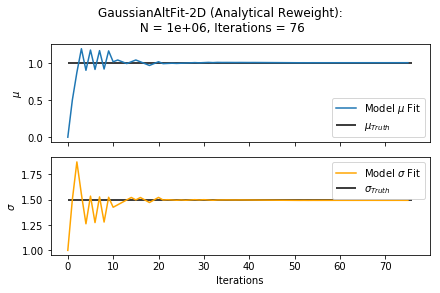

In [32]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}".format(N, len(fit_vals)))
axs[0].plot(fit_vals[:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:,1], label='Model $\sigma$ Fit', color ='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}.png".format(N, len(fit_vals)))
plt.show()

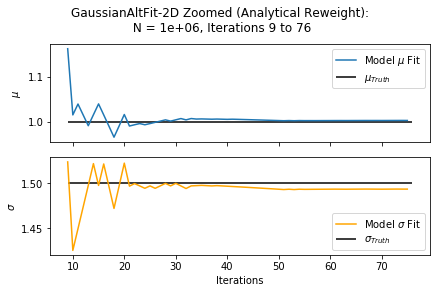

In [33]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex= True,  constrained_layout=True)
fig.suptitle("GaussianAltFit-2D Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}".format(N,index_refine[1], len(fit_vals)))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:,0])), fit_vals[index_refine[1]:,0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], index_refine[1], len(fit_vals), label = '$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:,1])), fit_vals[index_refine[1]:,1], label='Model $\sigma$ Fit', color = 'orange')
axs[1].hlines(theta1_param[1], index_refine[1], len(fit_vals), label = '$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
plt.savefig("GaussianAltFit-2D Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(N,index_refine[1], len(fit_vals)))
plt.show()